In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

In [3]:
df = pd.read_excel("/content/drive/MyDrive/Hugo's Portfolio/Realized Volatility Predictability through Neural Network and Financial Turbulence Research/New Version/Model 1/DJIA Realized Volatility.xlsx",index_col='Date',parse_dates=True)

In [4]:
df.head()

,Realised,US Financial Turbulence
Date,,
2017-11-02,0.005718,806.442547
2017-11-03,0.002881,702.337034
2017-11-06,0.001528,529.197112
2017-11-07,0.003651,512.157114
2017-11-08,0.001921,493.752126


In [5]:
df_train=df[:int(len(df["Realised"])*0.7)]

Text(0, 0.5, 'Realized Volatility')

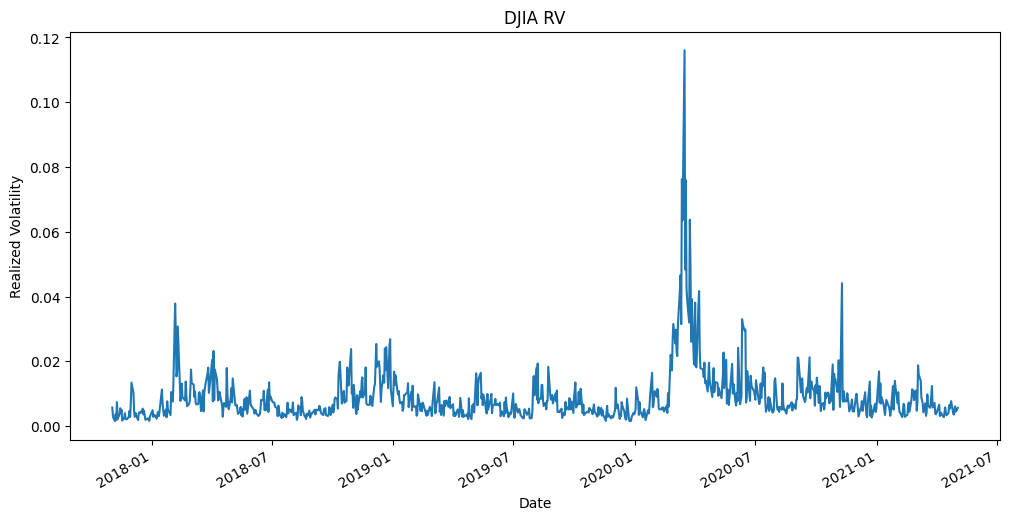

In [6]:
df_train["Realised"].plot(figsize=(12,6))
plt.title("DJIA RV")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")

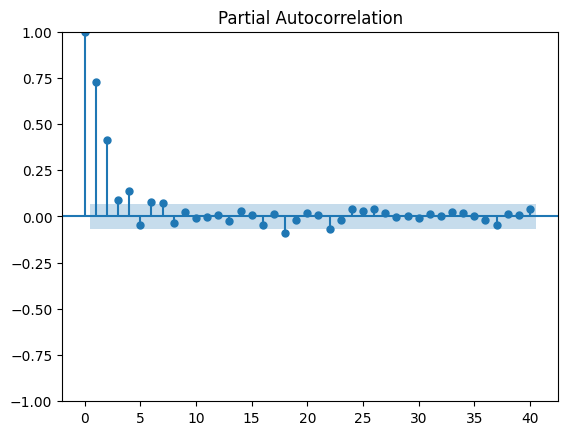

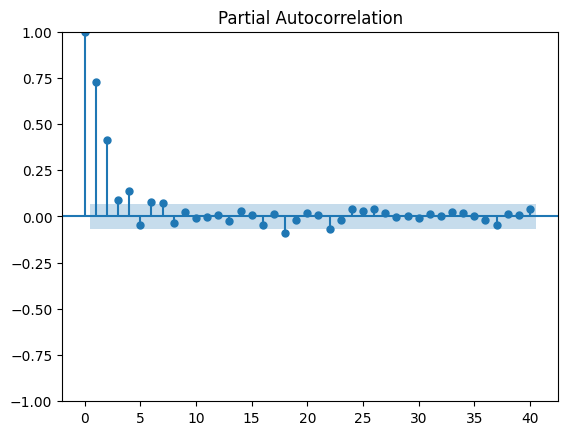

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train["Realised"], lags = 40, method = "ols")

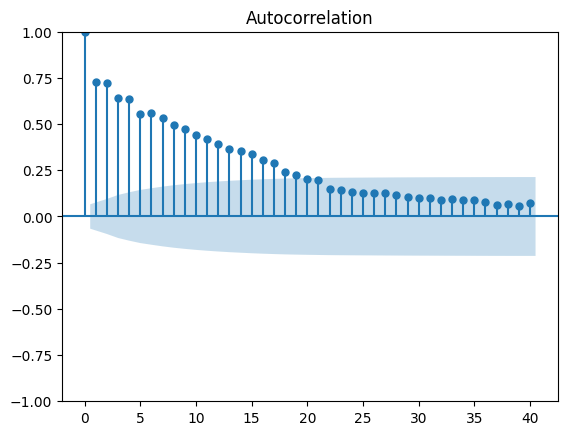

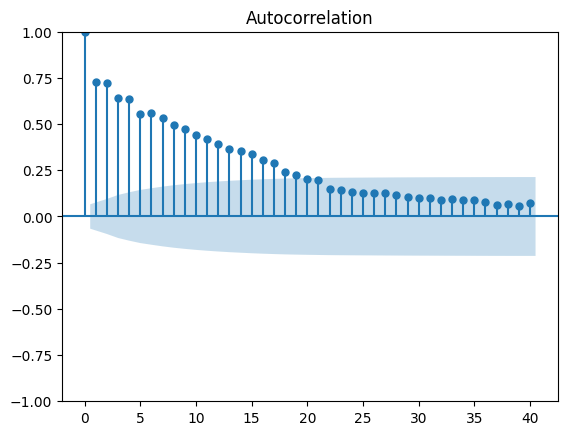

In [8]:
plot_acf(df_train["Realised"], lags = 40) 

# Augmented Dickey Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_train["Realised"])

(-4.588529378874345,
 0.0001356060733743371,
 6,
 872,
 {'1%': -3.4378713927343156,
  '5%': -2.8648601928465505,
  '10%': -2.568537914369582},
 -6520.495928746048)

# Breusch Godfrey test

In [10]:
df_for_Breusch_Godfrey_test = df_train.reset_index(drop=True)

In [11]:
import statsmodels.api as sm
y = df_for_Breusch_Godfrey_test["Realised"]
x = df_for_Breusch_Godfrey_test[['Realised']][:len(df_train["Realised"])-1]

In [12]:
for i in range(len(y)-1):
    y[i]=y[i+1]
y=y[:len(df_train["Realised"])-1]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
import statsmodels.stats.diagnostic as dg
print(dg.acorr_breusch_godfrey(model, nlags=10))

(179.38767846282474, 3.1396544966480966e-33, 22.19976850485668, 3.2787331127648913e-37)


# Ljung-Box Test

In [13]:
def sac(x, k=1):
    """
    ----------
    x : 1d numpy array
        Signal
    k : int or list of ints
        Lags to calculate sample autocorrelation for
    Returns
    -------
    res : scalar or np array
        The sample autocorrelation. A scalar value if k is a scalar, and a
        numpy array if k is a interable.
    """
    try:
        res = []
        for ki in k:
            res.append(sac(x, ki))
        return np.array(res)
    except:
        pass
    mx = np.mean(x)
    if k==0:
        N = np.sum((x-mx)*(x-mx))
    else:
        N = np.sum((x[:-k]-mx)*(x[k:]-mx))
    D = len(x) * np.var(x)
    return N/D


def ljungbox(x, lags, alpha=0.1):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2) / (n-k)
    Q = n*(n+2)*Q
    return Q

def boxpierce(x, lags, alpha=0.1):
    """
    The Box-Pierce test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2)
    Q = n*Q
    return Q

def lbqtest(x, lags, alpha=0.1, method='lb'):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : list of ints
        Lags being tested
    alpha : float
        Significance level used for the tests
    method : string
        Can be either 'lb' for Ljung-Box, or 'bp' for Box-Pierce
       
    Returns
    -------
    h : np array
        Numpy array of bool values, True == H0 hypothesis rejected
    pV : np array
        Test statistics p-values
    Q : np array
        Test statistics
    cV : np array
        Critical values used for determining if H0 should be rejected. The
        critical values are calculated from the given alpha and lag.
    """
    if method=='lb':
        findq = ljungbox
    else:
        findq = boxpierce
    n = len(x)
    Q = np.zeros(len(lags))
    pV = np.zeros(len(lags))
    cV = np.zeros(len(lags))
    for i, lag in enumerate(lags):
        Q[i] = findq(x, lag)
        pV[i] = 1.0 - scipy.stats.chi2.cdf(Q[i], lag)
        cV[i] = scipy.stats.chi2.ppf(1-alpha, lag)
    h = Q>cV
    return h, pV, Q, cV

In [14]:
h, pV, Q, cV = lbqtest(y, range(1, 25), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag   p-value          Q    c-value   rejectH0
1       0.000    879.695      2.706      True
2       0.000   1758.345      4.605      True
3       0.000   2637.013      6.251      True
4       0.000   3514.859      7.779      True
5       0.000   4392.849      9.236      True
6       0.000   5269.908     10.645      True
7       0.000   6147.182     12.017      True
8       0.000   7024.995     13.362      True
9       0.000   7902.825     14.684      True
10      0.000   8781.078     15.987      True
11      0.000   9658.244     17.275      True
12      0.000  10534.401     18.549      True
13      0.000  11410.273     19.812      True
14      0.000  12285.652     21.064      True
15      0.000  13160.176     22.307      True
16      0.000  14033.665     23.542      True
17      0.000  14906.865     24.769      True
18      0.000  15779.395     25.989      True
19      0.000  16652.025     27.204      True
20      0.000  17524.205     28.412      True
21      0.000  18397.205     29.6

In [15]:
from pandas.plotting import lag_plot

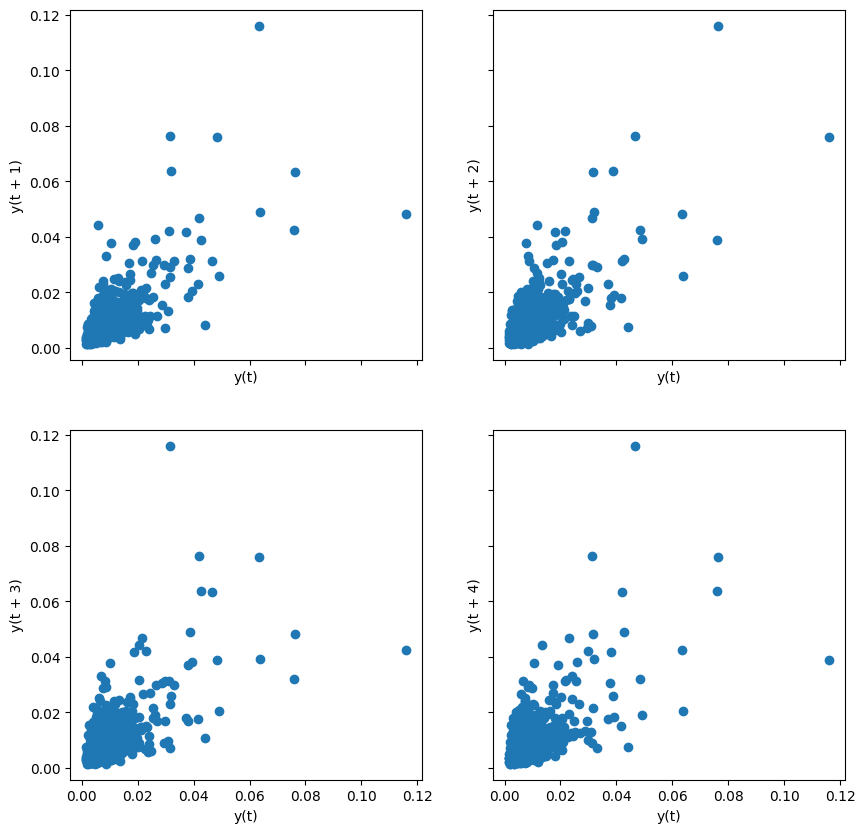

In [16]:
plot_lags = 10
rows = int(plot_lags/5)
cols = int(plot_lags/5)
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
fig.set_figwidth(plot_lags)
fig.set_figheight(plot_lags)
count =1
for i in range(rows):
    for j in range(cols):
        lag_plot(df_train["Realised"], lag=count, ax=axes[i, j])
        count+=1